In [1]:
!pwd

/content


### **Cloning the Github Repository for Global Earthquake Dataset (Stanford Geo Sci 240)**

In [2]:
!git clone https://github.com/sdyinzhen/GS240_resources.git

Cloning into 'GS240_resources'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 64 (delta 21), reused 47 (delta 10), pack-reused 0
Unpacking objects: 100% (64/64), done.


In [3]:
!ls

GS240_resources  sample_data


In [4]:
cd GS240_resources/

/content/GS240_resources


In [5]:
cd EVS_Earthquakes/

/content/GS240_resources/EVS_Earthquakes


In [6]:
!ls

asia_earthquakes.csv		      Load_view_Dataset.ipynb
global_database.csv		      Load_view_Dataset.pdf
InterarrivalTimes_larger_than_M6.csv  north_america_earthquakes.csv
InterarrivalTimes_larger_than_M7.csv


### **Overview of Earthquake dataset (1965- 2016)**

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [ ]:
inter_time6 = pd.read_csv('InterarrivalTimes_larger_than_M6.csv')['Interarrival times (>M6)'].str.replace("days","").astype(int)
inter_time7 = pd.read_csv('InterarrivalTimes_larger_than_M7.csv')['Interarrival times (>M7)'].str.replace("days","").astype(int)
earthq_file =  pd.read_csv('global_database.csv')
earthq_data =  pd.read_csv('global_database.csv')['Magnitude']


In [ ]:
pip install geopandas

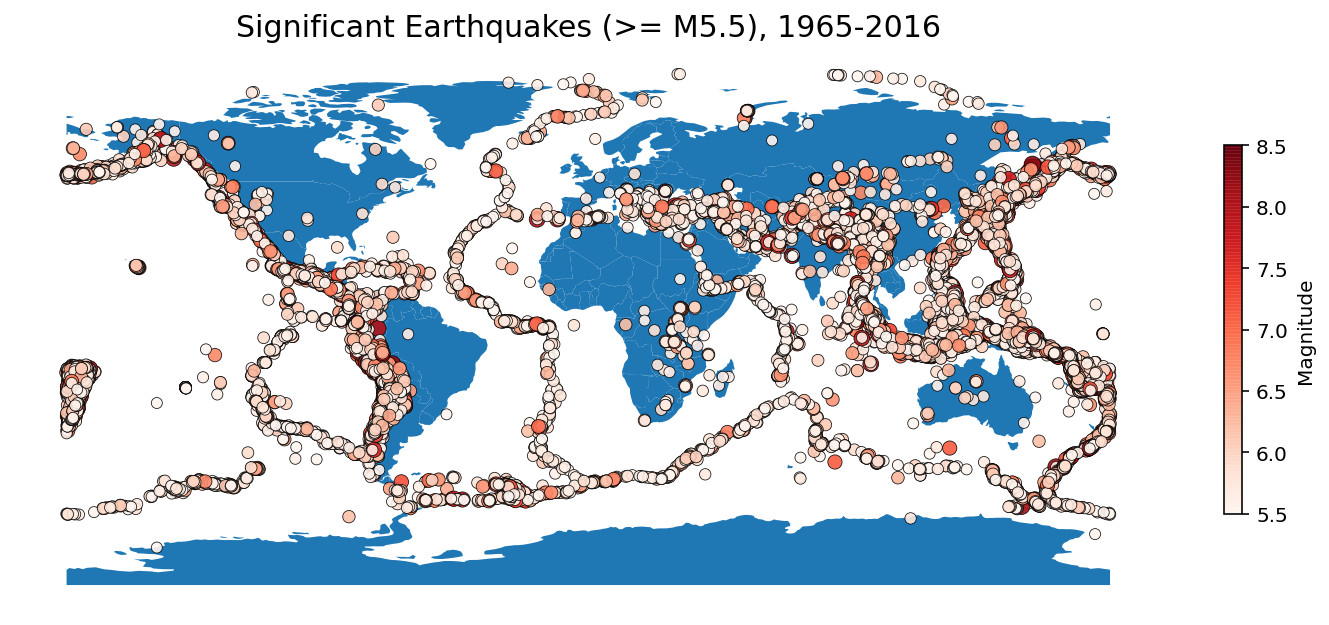

In [22]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import datetime

geometry = [Point(xy) for xy in zip(earthq_file['Longitude'], earthq_file['Latitude'])]
gdf = GeoDataFrame(earthq_file[['Longitude', 'Latitude']], geometry=geometry)   
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# gdf.plot(ax=, marker='o', color='red', markersize=15);

world.plot(figsize=(11, 6))
plt.scatter(earthq_file['Longitude'], earthq_file['Latitude'], marker='o', 
         c=earthq_file['Magnitude'],cmap='Reds', vmin = 5.5, vmax= 8.5, alpha=0.9,
         s=earthq_file['Magnitude']**2, linewidths=0.4, edgecolors='k')


plt.colorbar(label='Magnitude',fraction=0.015)

plt.title('Significant Earthquakes (>= M5.5), 1965-2016', fontsize = 15)
plt.axis('off')
plt.show()

### **Plotting the Interarrival times between significant earthquakes in an Exponential Q-Q Plot to explore Linearity**

Text(0, 0.5, 'Interarrival time (days)')

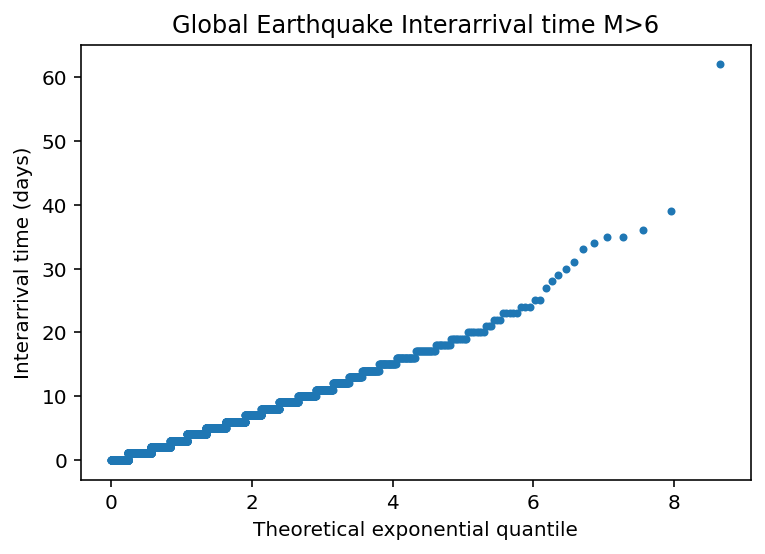

In [24]:
def exponential_quantile(data):
    data = np.sort(data)[::-1]
    n = len(data)
    P_X_larger_x = np.arange(1,n+1)/(n+1)
    fig = plt.figure()
    plt.plot(-np.log(P_X_larger_x),data,'.')
    plt.xlabel('Theoretical exponential quantile')
    plt.ylabel('Empirical quantile')


exponential_quantile(inter_time6)
plt.title('Global Earthquake Interarrival time M>6')
plt.ylabel('Interarrival time (days)')


Text(0, 0.5, 'Interarrival time (days)')

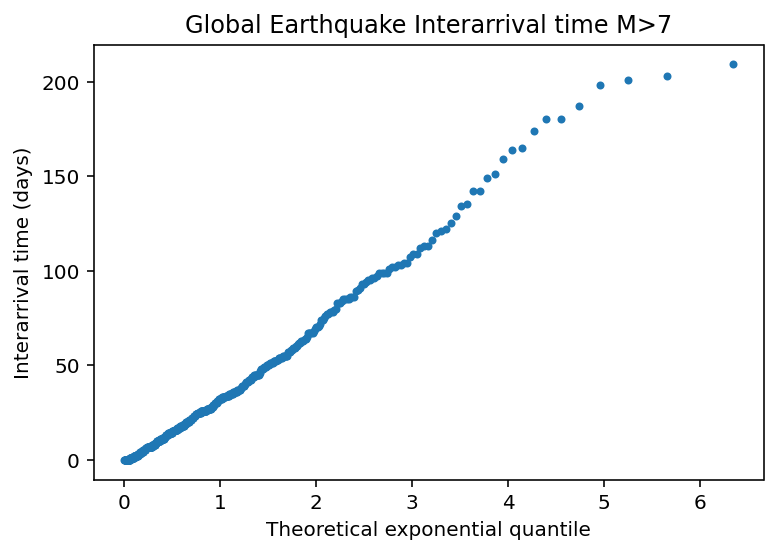

In [25]:
exponential_quantile(inter_time7)
plt.title('Global Earthquake Interarrival time M>7')
plt.ylabel('Interarrival time (days)')

- The linearity between exponential quantiles and interarrival days of large earthquakes (M> 6 and M>7 richter scales) shows that the arrival of large earthquakes follow exponential distribution. Exponential distribution is often called the 'memoryless distribution' because the events are random and not correlated. This statistically proves that large earthquakes are truely random and not influenced by arrival of the other

### **Creating a Return Period plot of the Earthquakes to extrapolate for 1000 year event estimation**

In [11]:
## calculate empirical return period
empirical_M = np.unique(np.sort(earthq_data))
empirical_return_period = np.zeros(len(empirical_M))
for i, vei in enumerate(empirical_M):
    empirical_return_period[i] = (2016-1965)/np.sum(earthq_data>=vei)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  import sys


(4.0, 12.0)

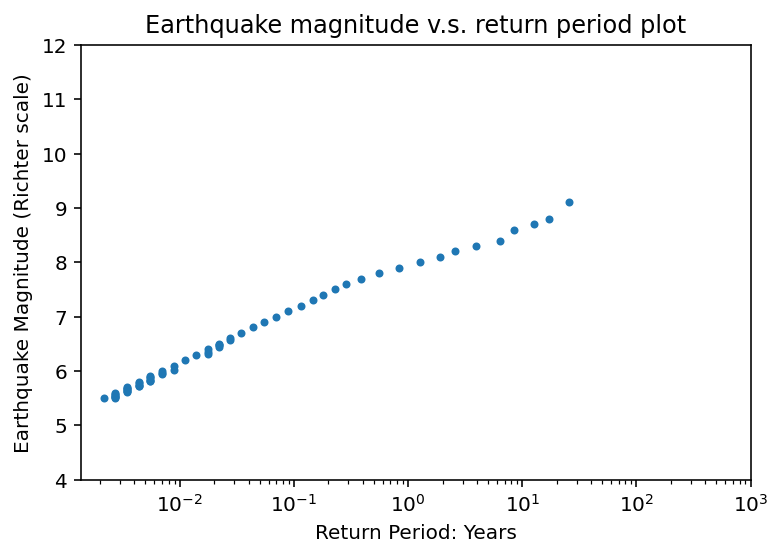

In [30]:
## Empirical return period v.s. return level plot
plt.plot(empirical_return_period,empirical_M,'.')
plt.xscale('log',basex = 10)
plt.xlabel('Return Period: Years')
plt.ylabel('Earthquake Magnitude (Richter scale)')
plt.title('Earthquake magnitude v.s. return period plot')
plt.xlim([0, 1000])
plt.ylim([4, 12])


- We have a linear relationship between return level $X$ and logarithm of the return period $T(x)$. Extrapolationg from the linearity of the plot visually, a 1000 year earthquake seems to have the magnitude of slightly over 10 Richter scale.

### **Fitting  General Pareto Distribution to estimate the maximum Statistical limit of an earthquake magnitude** 

Here, for our sample size of the earthquake dataset (~24000), we will use Peaks Over Threshold method to fit General Pareto Distribution (GPD):

1.   Select a threshold $u$
2.   Extract the exceedances from the dataset, find all data larger than $u$
3.   Fit Generalized Pareto Distribution to the exceedances:
     Exceedances of the dataset is a Generalized Pareto Distribution. 
     $$GPD(y) = P(X\leq u+y|X>u) = 1- P(X>u+y|X>u)$$
4.   Then for any return value $x$, if we denote $x = u+y$:
$$P(X>x) = P(X>u+y)  = P(X>u+y|X>u)P(X>u) = (1-GPD(y))P(X>u)$$
$P(X>u)$ can be estimated empirically. 
Then the return period $T(x)$ is:
$$T(x) = \frac{1}{P(X>x)} = \frac{1}{(1-GPD(x-u))P(X>u)}$$
where $x>u$.

The simplest GPD is when $\xi= 0$, which is an exponential distribution: 
$$GPD(x) = 1-\exp\left(-\frac{(x-\mu)}{\sigma}\right)$$

In this simple case: 
$$P(X>x) = (1-GPD(y))P(X>u) = P(X>u)\exp\left(-\frac{(x-u-\mu)}{\sigma}\right)$$
Therefore, if we replace $P(X>x)$ with $T(x)$ and take a logarithm: 
$$x = \sigma\log(T(x)P(x>u))+\mu+u $$

where we have a linear relationship between return level $X$ and logarithm of the return period $T(x)$

In [13]:
u=min(earthq_data)
from scipy.stats import genpareto
xi, mu, sigma =genpareto.fit(earthq_data[earthq_data>u]-u)
print('xi: '+str(xi))

/usr/local/lib/python3.6/dist-packages/scipy/stats/_continuous_distns.py:2432: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1063: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


xi: -0.09213223123527647


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


Text(0.5, 1.0, 'Fitted return period v.s. return level plot, log-scale on T')

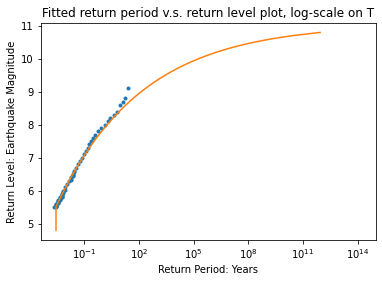

In [14]:
def return_period_function(return_level_x, u, xi, mu, sigma, data, time_interval =51):
    ## 1−𝐺𝑃𝐷(𝑦),y = x - u
    one_minus_GPD_y = 1-genpareto.cdf(return_level_x-u,xi,mu,sigma)

    ## Pu = 𝑃(𝑋>𝑢)
    Pu = np.sum(data>u)/time_interval

    ## P(X>x)
    exceedance_prob = one_minus_GPD_y*Pu

    ## T = 1/P(X>x)
    return_period_T = 1/exceedance_prob

    return return_level_x, return_period_T, one_minus_GPD_y

return_level_x, return_period_T, one_minus_GPD_y= return_period_function(np.arange(4.8,11,0.1), u, xi, mu, sigma, earthq_data, time_interval = 51)

## Fitted return period v.s. return level plot, log-scale on T
plt.plot(empirical_return_period,empirical_M,'.')
plt.plot(return_period_T,return_level_x)
plt.xscale('log',basex = 10)
plt.xlabel('Return Period: Years')
plt.ylabel('Return Level: Earthquake Magnitude')
plt.xlim([0, 10**15])
plt.title('Fitted return period v.s. return level plot, log-scale on T')

Text(10.9, 0, 'Max statistically possible magnitude=10.9 Richter scale')

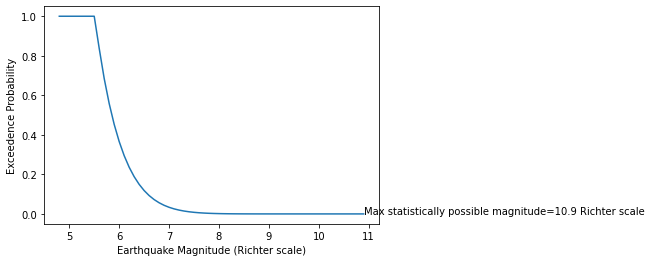

In [15]:
plt.figure()
plt.plot(return_level_x,one_minus_GPD_y)
plt.ylabel('Exceedence Probability')
plt.xlabel('Earthquake Magnitude (Richter scale)')
plt.text(round(max(return_level_x),2),0,'Max statistically possible magnitude='+str(round(max(return_level_x),2))+' Richter scale',horizontalalignment='left')

**- Therefore, the Statistical Upper Bound of Earthquake seems to be at 10.9 Richter Scale.**